In [24]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import pandas as pd
# Import the backtrader platform
import backtrader as bt
import backtrader.indicators as btind
#import pandas as pd
# to avoid plot disappear everytime rerun the code
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#plt.figure(figsize=(15,5))

# to avoid plot disappear everytime rerun the code
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
# create a data feed and set formet
#data_sentiment=bt.feeds.GenericCSVData(dataname="/Users/tyllersun/Desktop/大一/data_science/bond.csv")
#/Users/tyllersun/Desktop/data0.csv
#data_1 = bt.feeds.GenericCSVData(dataname='/Users/tyllersun/Desktop/data0_test.csv',
data_1 = bt.feeds.GenericCSVData(dataname='data0_new.csv',
fromdate=datetime.datetime(2015, 5, 1), # startdate
todate=datetime.datetime(2019, 1, 1), # enddate
                                     
dtformat=('%Y-%m-%d'),tmformat=('%H.%M.%S'),
    date=0, open=1, close=2, high=3, low=4,
    volume=7, openinterest=8, positive_std=-1, negative_std=-1 ,code=-1,
    reverse=False)
#print("finish")
#print(data_1.positive_std)

In [7]:
# Create a Stratey #Buy if price continuelly fall for 3d & Sell every 5d
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
                
        # To keep track of pending orders #掛單
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                                
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None      
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))    
    
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):  # 每過5天 -> sell!
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
               

In [25]:
class sentiment_strategy(bt.Strategy):
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                                
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None      
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))    
    
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        #print("s")
        #high
        #print(self.datas[0].volume)
        self.data_positive = self.datas[0].volume
        self.data_negative = self.datas[0].openinterest
        self.dataclose = self.datas[0].close
        #print("finish_init")
           
    def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('sentiment, %.2f' % self.dataclose[0])
        #print("a")
        time=10
        total_pos=0
        total_neg=0
        for i in range(time):
            where=i-14
            total_pos=total_pos+self.data_positive[where]
            total_neg=total_neg+self.data_negative[where]
        total_pos_avg=total_pos/time
        total_neg_avg=total_neg/time
        #print("b")
        if  total_pos_avg > self.data_positive[0]*(2.3):
            #print("w")
            print(total_pos_avg)
            self.log('BUY CREATE, %.2f' % self.dataclose[0])
            self.buy(size=5)
        else: 
            if total_neg_avg > self.data_negative[0]*(2.3):
                #print("c")
                print(total_neg_avg)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.sell(size=5)
       
    """"   
        if self.dataclose[0] < self.dataclose[-1]:
            # current close less than previous close

            if self.dataclose[-1] < self.dataclose[-2]:
                # previous close less than the previous close

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.buy()
        """

In [8]:
class RSI_Strategy(bt.Strategy):

    def __init__(self):
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period=21)

    def next(self):
        if not self.position:
            if self.rsi < 30:
                self.buy(size=100)
        else:
            if self.rsi > 70:
                self.sell(size=100)

In [17]:
class MA_CrossOver(bt.Strategy):
    '''This is a long-only strategy which operates on a moving average cross
    Note:
      - Although the default
    Buy Logic:
      - No position is open on the data
      - The ``fast`` moving averagecrosses over the ``slow`` strategy to the
        upside.
    Sell Logic:
      - A position exists on the data
      - The ``fast`` moving average crosses over the ``slow`` strategy to the
        downside
    Order Execution Type:
      - Market
    '''
    alias = ('SMA_CrossOver',)

    params = (
        # period for the fast Moving Average
        ('fast', 10),
        # period for the slow moving average
        ('slow', 30),
        # moving average to use
        ('_movav', btind.MovAv.SMA)
    )

    def __init__(self):
        sma_fast = self.p._movav(period=self.p.fast)
        sma_slow = self.p._movav(period=self.p.slow)

        self.buysig = btind.CrossOver(sma_fast, sma_slow)

    def next(self):
        if self.position.size:
            if self.buysig < 0:
                self.sell()

        elif self.buysig > 0:
            self.buy()

In [26]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10, 8  # that's default image size for this interactive session

pylab.rcParams['font.family'] = 'Segoe Script'
pylab.rcParams['font.sans-serif'] = ['Segoe Script']

#pylab.rcParams['font.family'] = 'sans-serif'
#pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
pylab.rcParams["font.size"] = "10"

Starting Portfolio Value: 100000.00
-0.32755296085105845
2015-05-01, BUY CREATE, 163.89
2015-05-04, BUY EXECUTED, Price: 164.19, Cost: 820.96, Comm 0.82
0.4415548049463351
2015-05-04, SELL CREATE, 164.84
2015-05-05, SELL EXECUTED, Price: 164.09, Cost: 820.96, Comm 0.82
2015-05-05, OPERATION PROFIT, GROSS -0.50, NET -2.14
0.4335854052452987
2015-05-05, SELL CREATE, 164.42
2015-05-06, SELL EXECUTED, Price: 163.76, Cost: -818.82, Comm 0.82
-0.25007101567686385
2015-05-06, BUY CREATE, 164.11
2015-05-07, BUY EXECUTED, Price: 162.17, Cost: -818.82, Comm 0.81
2015-05-07, OPERATION PROFIT, GROSS 7.97, NET 6.34
0.47014865399192524
2015-05-07, SELL CREATE, 163.61
2015-05-08, SELL EXECUTED, Price: 164.92, Cost: -824.60, Comm 0.82
0.45453015660232765
2015-05-08, SELL CREATE, 165.72
2015-05-11, SELL EXECUTED, Price: 165.49, Cost: -827.46, Comm 0.83
-0.09510460338833457
2015-05-11, BUY CREATE, 165.70
2015-05-12, BUY EXECUTED, Price: 163.97, Cost: -826.03, Comm 0.82
0.2617682014058116
2015-05-12, SEL

-0.2028749844069036
2015-11-27, SELL CREATE, 164.63
2015-11-30, SELL EXECUTED, Price: 164.58, Cost: 793.06, Comm 0.82
-0.311093719190282
2015-11-30, BUY CREATE, 164.77
2015-12-01, BUY EXECUTED, Price: 164.39, Cost: 821.95, Comm 0.82
-0.468675839950249
2015-12-01, BUY CREATE, 165.29
2015-12-02, BUY EXECUTED, Price: 165.05, Cost: 825.27, Comm 0.83
-0.6103249184355989
2015-12-02, BUY CREATE, 165.42
2015-12-03, BUY EXECUTED, Price: 164.15, Cost: 820.75, Comm 0.82
-0.34220944975378315
2015-12-03, BUY CREATE, 164.32
2015-12-04, BUY EXECUTED, Price: 161.92, Cost: 809.61, Comm 0.81
0.5603547023790435
2015-12-04, SELL CREATE, 165.09
2015-12-07, SELL EXECUTED, Price: 164.48, Cost: 795.56, Comm 0.82
-0.36746291347990095
2015-12-07, BUY CREATE, 164.54
2015-12-08, BUY EXECUTED, Price: 162.32, Cost: 811.60, Comm 0.81
-0.36430737355640225
2015-12-08, BUY CREATE, 163.41
2015-12-09, BUY EXECUTED, Price: 162.10, Cost: 810.49, Comm 0.81
-0.5695018733554074
2015-12-09, BUY CREATE, 164.24
2015-12-10, BUY E

2016-08-18, BUY CREATE, 174.96
2016-08-19, BUY EXECUTED, Price: 174.53, Cost: 872.67, Comm 0.87
-0.5171704180210919
2016-08-19, BUY CREATE, 174.86
2016-08-22, BUY EXECUTED, Price: 174.20, Cost: 871.02, Comm 0.87
-0.47933960315586593
2016-08-22, BUY CREATE, 174.73
2016-08-23, BUY EXECUTED, Price: 174.91, Cost: 874.56, Comm 0.87
-0.0013095101787467644
2016-08-24, BUY CREATE, 174.44
2016-08-25, BUY EXECUTED, Price: 173.57, Cost: 867.87, Comm 0.87
-0.021908446721851806
2016-08-25, BUY CREATE, 174.05
2016-08-26, BUY EXECUTED, Price: 173.89, Cost: 869.47, Comm 0.87
-0.06766212300602845
2016-08-26, BUY CREATE, 174.76
2016-08-29, BUY EXECUTED, Price: 173.15, Cost: 865.75, Comm 0.87
-0.20669603784277765
2016-08-30, BUY CREATE, 174.39
2016-08-31, BUY EXECUTED, Price: 173.55, Cost: 867.73, Comm 0.87
-0.38436922834667875
2016-08-31, BUY CREATE, 173.65
2016-09-01, BUY EXECUTED, Price: 173.06, Cost: 865.28, Comm 0.87
-0.5498859753281359
2016-09-01, BUY CREATE, 173.57
2016-09-02, BUY EXECUTED, Price:

2017-06-21, SELL EXECUTED, Price: 206.11, Cost: 890.41, Comm 1.03
-0.30862917234707765
2017-06-21, BUY CREATE, 206.13
2017-06-22, BUY EXECUTED, Price: 205.56, Cost: 1027.82, Comm 1.03
-0.38337062039565345
2017-06-22, BUY CREATE, 205.77
2017-06-23, Order Canceled/Margin/Rejected
-0.23870793642558114
2017-06-23, BUY CREATE, 205.44
2017-06-26, Order Canceled/Margin/Rejected
-0.015261504993053298
2017-06-26, SELL CREATE, 206.22
2017-06-27, SELL EXECUTED, Price: 205.21, Cost: 891.59, Comm 1.03
-0.2041363122024534
2017-06-27, BUY CREATE, 205.61
2017-06-28, BUY EXECUTED, Price: 205.08, Cost: 1025.42, Comm 1.03
-0.20334332099828467
2017-06-28, BUY CREATE, 206.00
2017-06-29, Order Canceled/Margin/Rejected
-0.19125847712713198
2017-06-29, BUY CREATE, 206.02
2017-06-30, Order Canceled/Margin/Rejected
-0.4116859836950855
2017-06-30, BUY CREATE, 205.48
2017-07-03, Order Canceled/Margin/Rejected
-0.2994227035600785
2017-07-03, SELL CREATE, 206.81
2017-07-05, SELL EXECUTED, Price: 206.20, Cost: 892.7

-0.01874888513846874
2018-04-20, BUY CREATE, 240.79
2018-04-23, BUY EXECUTED, Price: 239.23, Cost: 1196.16, Comm 1.20
-0.09523317158332482
2018-04-23, BUY CREATE, 239.35
2018-04-24, Order Canceled/Margin/Rejected
-0.2045903376559209
2018-04-25, BUY CREATE, 235.59
2018-04-26, Order Canceled/Margin/Rejected
0.3361612811148623
2018-04-27, SELL CREATE, 237.65
2018-04-30, SELL EXECUTED, Price: 238.29, Cost: 971.04, Comm 1.19
0.369211715788487
2018-04-30, SELL CREATE, 239.02
2018-05-01, SELL EXECUTED, Price: 234.97, Cost: 971.04, Comm 1.17
-0.1917366494232594
2018-05-01, BUY CREATE, 235.16
2018-05-02, BUY EXECUTED, Price: 234.89, Cost: 1174.44, Comm 1.17
0.3408700037052418
2018-05-02, SELL CREATE, 235.95
2018-05-03, SELL EXECUTED, Price: 232.26, Cost: 972.79, Comm 1.16
-0.15333838141892212
2018-05-03, BUY CREATE, 234.13
2018-05-04, BUY EXECUTED, Price: 232.45, Cost: 1162.24, Comm 1.16
-0.08142193156237269
2018-05-04, BUY CREATE, 237.44
2018-05-07, BUY EXECUTED, Price: 237.71, Cost: 1188.54, 

<IPython.core.display.Javascript object>


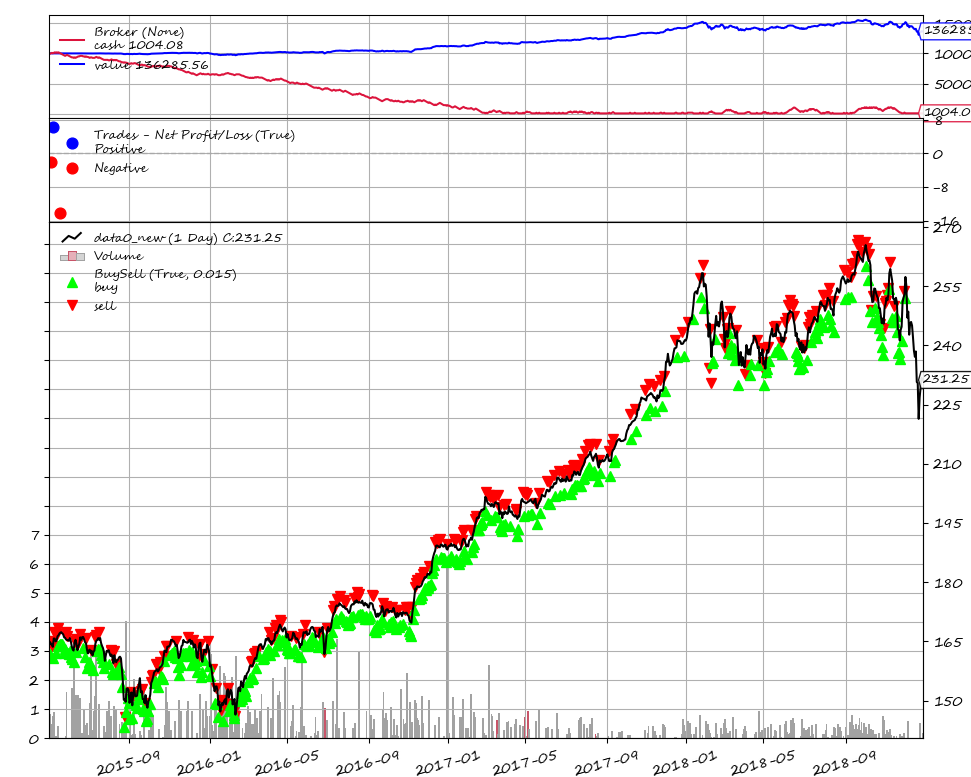

In [27]:
import pandas as pd
if __name__ == '__main__':
    #sentiment=pd.read_excel("/Users/tyllersun/Desktop/大一/data_science/bond.csv")
    cerebro = bt.Cerebro() # creat the "brain"

    # Add a strategy
    cerebro.addstrategy(sentiment_strategy)

    cerebro.adddata(data_1)
    
    cerebro.broker.setcash(100000.0) # the "manager"
    
    # Set the commission - 0.1% ... divide by 100 to remove the % #手續費
    cerebro.broker.setcommission(commission=0.001)
    
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.run() # run over everything
    
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue()) 
    
    cerebro.plot() # plot the result

Starting Portfolio Value: 100000.00
Final Portfolio Value: 102119.15


<IPython.core.display.Javascript object>


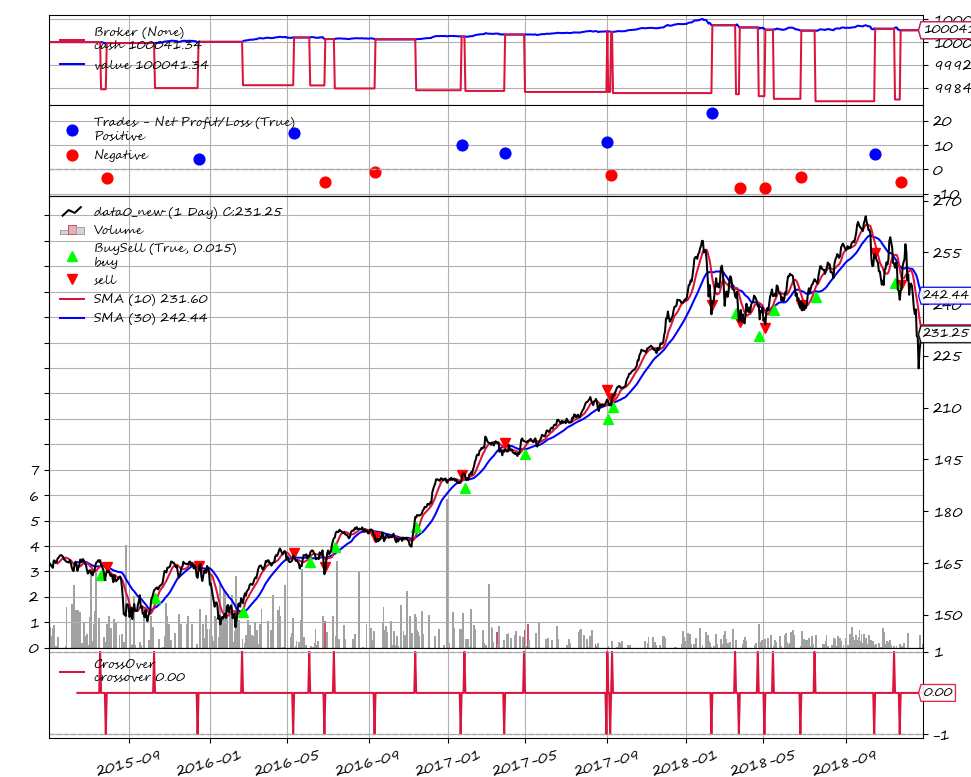

In [15]:
if __name__ == '__main__':
    #sentiment=pd.read_excel("/Users/tyllersun/Desktop/大一/data_science/bond.csv")
    cerebro = bt.Cerebro() # creat the "brain"

    # Add a strategy
    cerebro.addstrategy(RSI_Strategy)

    cerebro.adddata(data_1)
    
    cerebro.broker.setcash(100000.0) # the "manager"
    
    # Set the commission - 0.1% ... divide by 100 to remove the % #手續費
    cerebro.broker.setcommission(commission=0.001)
    
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.run() # run over everything
    
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue()) 
    
    cerebro.plot() # plot the result

Starting Portfolio Value: 100000.00
Final Portfolio Value: 100041.34


<IPython.core.display.Javascript object>


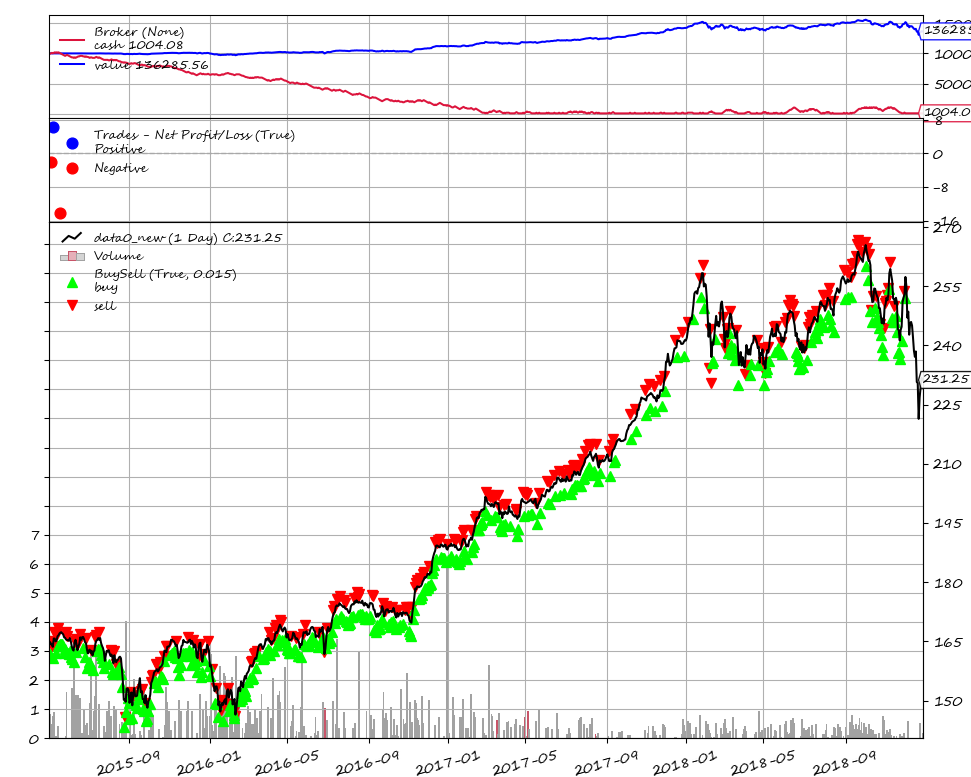

In [22]:
if __name__ == '__main__':
    #sentiment=pd.read_excel("/Users/tyllersun/Desktop/大一/data_science/bond.csv")
    cerebro = bt.Cerebro() # creat the "brain"

    # Add a strategy
    cerebro.addstrategy(MA_CrossOver)

    cerebro.adddata(data_1)
    
    cerebro.broker.setcash(100000.0) # the "manager"
    
    # Set the commission - 0.1% ... divide by 100 to remove the % #手續費
    cerebro.broker.setcommission(commission=0.001)
    
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.run() # run over everything
    
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue()) 
    
    cerebro.plot() # plot the result
